# Wildfires in the US
## An Application of Geopandas, Rasterio, and Zonalstats

In [ ]:
import numpy
import matplotlib.pyplot as plt
import geopandas
import pyproj
import rasterio
import rasterstats

In [ ]:
data_dir = "C:/Users/jhtchns2/Box/ACE 592 SAE Spring 2022/Class Examples/2_Images/"

The objective of this lecture is to demonstrate how to:
1. Read shape files.
2. Read and edit rasters.
3. Calculate zonal stats from:
    - A raster and a shape file
    - A shape file and a shape file


## Step 1: Reading shape files

### US States
Below is a geojson file of US states which is read into the dataframe as a geopandas dataframe

In [ ]:
state_file = data_dir + "us_states.json"

country = geopandas.read_file(state_file)

What is a geopandas dataframe?

Essentially, it is the same as a pandas dataframe but with geographic methods. For example:
- It has a column called "geometry" which stores a `shapely` polygon or multi-polygon object.
- Has geographic information embedded (like the CRS).
- Default plot method makes a spatial plot.

In [ ]:
country.head()

In [ ]:
print(type(country['geometry'][4]))
country['geometry'][4]

In [ ]:
country.crs

In [ ]:
country.plot()

The frame is a bit big. What if we just wanted to look at the continental US?

Do what you would do usually with a Pandas dataframe!

In [ ]:
country = country[~country['NAME'].isin(["Alaska","Hawaii","Puerto Rico"])]

country.plot(color="Grey")

These dataframes have very useful methods and attributes:
- `centroid`, which can extract the centroid from the shape.
- `to_crs()`, which can change the projection.
- `distance()`, which can tell you the distance between each row and a specific geometry.

Let's use these methods to find the distance between the Alabama centroid and every other state centroid.

In [ ]:
f,a = plt.subplots()
country.plot(ax=a)
country.centroid.plot(ax=a,color="white")

User warning! What did we do wrong?

In [ ]:
country_proj = country.to_crs(epsg=4087) # WGS 84 Equidistant Cylndrical
country_proj.plot()

In [ ]:
country_proj.centroid

In [ ]:
f,a = plt.subplots(figsize=(10,4))
country_proj.plot(ax=a,zorder=1,color='gray')
country_proj.centroid.plot(ax=a,color="white",markersize=5)

The `distance` function works on a series, but requires a geometry object to be passed right to the function.

In [ ]:
bama_cent = country_proj.centroid[0]

In [ ]:
country_proj['bama_dist'] = country_proj.centroid.distance(bama_cent)/1000 # res is in meters, so converting to km
country_proj.sort_values("bama_dist").head()

In [ ]:
f,a = plt.subplots(figsize=(15,5))
country_proj.plot(column="bama_dist", # The data it uses to assign colors
                  ax=a,\
                  legend=True,\
                  legend_kwds={'label': "Centroid Distance (km)"});
country_proj.centroid[:1].plot(color="C3",ax=a,markersize=10);
country_proj.centroid[1:].plot(color="w",ax=a,markersize=5);

plt.axis("off");
plt.title("State Centroid Distance from Alabama")


### Notice:
Some cool functionality of the plotting function is that it has built in ability to do chloropleth maps very easily!

Going back to the code that I just wrote:

In [ ]:
f,a = plt.subplots(figsize=(7,6))
country_proj.plot(column="bama_dist", # the column argument colors states by the value of that column.
                  ax=a,
                  cmap="viridis", # set your own colormap.
                  legend=True, # setting the legend as true leads to a color bar being plotted.
                  legend_kwds={'label': "Centroid Distance (km)",# this labels it.
                               'orientation': "horizontal"}); # this changes the orientation.
plt.axis("off");
plt.savefig("war_eagle_roll_tide.png")

## Wildfires
To demonstrate spatial joins, let's say we want to look at wildfires. NASA keeps a very [nice database on active fires](https://firms.modaps.eosdis.nasa.gov/active_fire/#firms-shapefile).

This one is a shapefile from NASA which was callected using their MODIS instrument. These are all the fires from October 20th 2020 until October 27th 2020.

In [ ]:
fires = geopandas.read_file("../../Data/Images/MODIS_C6_USA_contiguous_and_Hawaii_7d/MODIS_C6_USA_contiguous_and_Hawaii_7d.shp")
fires.head()

Before we go plotting them together, let's do a projection check.

#### Projection check

In [ ]:
country.crs == fires.crs

We're good to go!

Notice that instead of "polygons," we have "point" objects.

If we plot them on top of each other we get this:

In [ ]:
f,a = plt.subplots(figsize=(20,20))
country.plot(ax=a,color="grey")
fires.plot(color="C3",markersize=10,ax=a)

So notice that our fire data is in Mexico as well as Canada. How do we only look at fires in the US?

Intuitively, we look for the overlap. Restricting a shape file based on another shapefile is called __clipping__.

Geopandas has a great clipping function: 

In [ ]:
print(fires.shape)
print(geopandas.clip(fires,country).shape)

The first argument is the thing you want clipped, the second argument is the mask used to clip it.

So it looks like clipping got rid of about 500 fires.

In [ ]:
fires = geopandas.clip(fires,country)

f,a = plt.subplots(figsize=(20,20))
country.plot(ax=a,color="grey")
fires.plot(color="C3",markersize=10,ax=a);

Using the geopandas plotting function, we can actually color the dots according to one of the variables.

We will do it here according to the column "brightness."

In [ ]:
f,a = plt.subplots(figsize=(20,10))

country.plot(ax=a,color="grey")

geopandas.clip(fires,country).plot(markersize=10, # set the markersize 
                                   ax=a, # use the current axis we created
                                   column='BRIGHTNESS', #column to use
                                   cmap="OrRd", # colormap to use
                                   scheme='quantiles', # this keyword breaks the categories on quantiles.
                                   legend=True); # show a legend

### What is a spatial join?
Spatial joining is essentially executing a merge between two shapefiles. Instead of using indexes it uses their spatial positions.

For example, what if we wanted to count the number of fires in a given state?

In [ ]:
fires_w_state = geopandas.sjoin(fires,\
                                country,\
                                how='left')

state_w_fires = geopandas.sjoin(fires,\
                                country,\
                                how='right')

fires_w_state.shape, state_w_fires.shape


They look about the same size, what was the difference between the left and right merge?

In [ ]:
fires_w_state.head().geometry, state_w_fires.head().geometry

With spatial joins in geopandas dataframes, only one set of geometry will be retained. So make sure you understand how you are merging things!

Both of these dataframes could be useful in different ways.

In [ ]:
f,a = plt.subplots(figsize=(20,10))
country.plot(color='gray',ax=a)
fires_w_state.plot(column="CENSUSAREA",ax=a)
plt.title("Fires Colored by Census Area")

Let's get a count of fires per state.

In [ ]:
state_w_fires.groupby("NAME")['index_left'].count().head()

In [ ]:
state_fire_counts = state_w_fires.groupby("NAME")['index_left'].count().reset_index()

state_fire_counts.columns = ["NAME","fire_number"]

state_fire_counts.head()

In [ ]:
country = country.merge(state_fire_counts,how='left')

In [ ]:
f,a = plt.subplots(figsize=(20,10))
country.plot(column="fire_number",
             ax=a,
             cmap="OrRd",
            legend=True)

California and Colorado are clear outliers, could use the quantile method instead.

In [ ]:
f,a = plt.subplots(figsize=(20,10))
country.plot(column="fire_number",
             ax=a,
             cmap="OrRd",
            scheme="quantiles",
            legend=True)

### Dissolves

What if we wanted to merge polygons into one polygons? This is called a __dissolve__.

Geopandas make this very easy.

In [ ]:
country['country'] = "USA"

country.dissolve(by="country",aggfunc="sum").plot()

So now we have dissolved all of the states into one polygon. Dissolves are useful when you want to change the level of analysis.

## Step 2: Read in rasters

 Let's read in a raster file, in this case annual precipitation data from 2017 from [PRISM](https://prism.oregonstate.edu/recent/), a great source of historical weather data. 
 
 The package for reading in raster files is called `rasterio`

In [ ]:
import rasterio

raster_file = "../../Data/Images/Prism_ppt/PRISM_ppt_stable_4kmM3_2017_bil.bil"

raster = rasterio.open(raster_file)

In [ ]:
plt.imshow(raster.read()[0,:,:])

In this case, the file format is a .bil not a .tif

#### Projection check:

In [ ]:
raster.crs==country_proj.crs

So this is not what our shapefile currently is because we reprojected it...

Two ways we can go about this:
1. Reproject the raster file to match the shapefile (harder).
2. Reproject the shapefile to match the raster (easier).

It takes only one line to reproject geopandas dataframes, but much more code to do the same for rasterio. Here I'll demonstrate the raster way.

So what is the raster object anyway?

In [ ]:
raster.width,raster.height,raster.bounds

Notice that it is almost the same as a numpy array but it embeds geographic information. The function `read` will transform it into a numpy array.

In [ ]:
type(raster.read()),raster.read().shape

How can we use this info to translate it into a different coordinate system?

In [ ]:
raster.transform

Each raster contains an "affine transformation" which translates the pixel coordinates into geographic coordinates.

According to the docs, the above are coefficients to this equation:

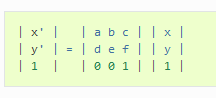

### Reprojecting a Raster

Essentially, we need to create a function that translates one "transformation" into another. We need to take the measurements of the first system and create a function that translates into a new system.

Now let's look at some code from [this question](https://gis.stackexchange.com/questions/337528/rasterio-reprojection-doesnt-seem-to-work]):

In [ ]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas

src_file = raster_file
dst_file = 'ppt_reproj.tif'
dst_crs = rasterio.crs.CRS.from_dict({'init': 'EPSG:4087'})

The following code does the reprojection... but what is it actually doing?

In [ ]:
with rasterio.open(src_file) as src: 
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds) 
    kwargs = src.meta.copy() 
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rasterio.open(dst_file, 'w', **kwargs) as dst: 
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)


### Discuss in groups!

In [ ]:
raster = rasterio.open("./ppt_reproj.tif")

raster.crs

In [ ]:
ppt = raster.read(1)

ppt

So now we have a Numpy array. Here's what it looks like plotted:

In [ ]:
plt.imshow(ppt,cmap="Blues")

##### Reminder

the difference between a raster and a usual numpy array is that rasters are georeferenced. So rasters have info like this:

In [ ]:
raster.crs

In [ ]:
raster.bounds

But reading it as a numpy array it no longer has this data, it's simply a matrix.

To understand why this important, lets look at what it would take to "clip" a raster to a specific state like Illinois

### Clipping and Editing Rasters

What if we only wanted a raster of Illinois and not the entire US? We would have to essentially "mask" the raster just we like would usually mask an array, but this time ommit everything outside of the Illinois border.

The way this works:
1. Find the Illinois coordinates
2. Use the rasterio "mask" function to get back an edited array.
    - NOTE: when we do this, the resulting array LOSES its geographic data, so we have to write it back with the geographic information.
3. Re-embed geographic data
4. Write out clipped raster
5. Read it back in

#### 1. Find the Illinois Coordinates
Each geopandas geometry object contains the coordinates that the rasterio function wants.

In [ ]:
import json

json.loads(country_proj[country_proj.NAME=="Illinois"]['geometry'].to_json())['features'][0]['geometry']

This is the data we need to load into the function, so we can make a fancy function (this is from [this documentation](https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html)):

Essentially, this function takes a GeoDataFrame and extracts the coordinates it needs.

In [ ]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

IL_coords = getFeatures(country_proj[country_proj.NAME=="Illinois"])

What they look like plotted:

In [ ]:
coords = np.array(IL_coords[0]['coordinates'][0])
plt.plot(coords[:,0],coords[:,1],color='black')

Rasterio has its own `mask` function that can help us with this. It takes the raster object as the first argument and our coordinates as the second:

In [ ]:
from rasterio.mask import mask

img_out, img_transform = mask(raster,IL_coords)

Plotted it looks like this:

In [ ]:
plt.imshow(img_out[0],cmap="Blues")

So now we have just Illinois. But notice now that the indices dont have anything to do with geo-coordinates. How do we get this info back?

The second output of the function "mask" is the directions on how to translate them back:

In [ ]:
img_transform

To make this a raster again, we can write it back as a raster while re-embedding the metadata

In [ ]:
out_meta = raster.meta.copy()

out_meta['height'] = img_out.shape[1]
out_meta['width'] = img_out.shape[2]
out_meta['transform'] = img_transform

with rasterio.open("./IL_PPT.tif", "w", **out_meta) as dest:
    dest.write(img_out)

In [ ]:
IL_raster = rasterio.open("./IL_PPT.tif")

In [ ]:
IL_raster.read(1)

In [ ]:
from rasterio.plot import show

fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(IL_raster, ax=ax,cmap="Blues")
country_proj.plot(ax=ax, facecolor='none', edgecolor='black')

Nice!

With this technique, a huge upside is that __we can edit rasters just like numpy arrays__ as long as we write the data back with the right metadata.

For example, what if we wanted a raster of zeros and ones indicating if rainfall hits a certain threshhold, for example the state average?

### Making a New Raster

In [ ]:
import pandas as pd
IL_vals = pd.Series(IL_raster.read(1).flatten())

IL_avg = IL_vals[IL_vals!=-9999].describe()['mean']

In [ ]:
IL_avg

Do it like this: 

In [ ]:
IL_r_vals = IL_raster.read(1)

In [ ]:
img_out = (IL_r_vals>IL_avg)[np.newaxis,:,:].astype(np.float32)

__NOTE:__ A couple of things happened up there:
1. We made a boolean array by coding "True" if the rainfall was above the average
2. We added an axis so the array is three dimensions using "np.newaxis"; raster always are three dimensional arrays, the first dimension being the band and the second and third being the rows and the columns. We need to put a "band" dimension into any array before it can be written to raster.
3. We converted the "booleans" to float32 to make it play nice with Rasterio

Now change the metadata

In [ ]:
out_meta = IL_raster.meta.copy()

out_meta['height'] = img_out.shape[1]
out_meta['width'] = img_out.shape[2]
out_meta['transform'] = img_transform

with rasterio.open("./example.tif", "w", **out_meta) as dest:
    dest.write(img_out)

In [ ]:
IL_raster = rasterio.open("./example.tif")

fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(IL_raster, ax=ax,cmap="Blues")
country_proj.plot(ax=ax, facecolor='none', edgecolor='black')
plt.xlim(-1.03*10**7,-.97*10**7)
plt.ylim(4.1*10**6,4.8*10**6)

### The above is an important skill for Homework 2

## Step 3: Zonal Statistics

The next step is doing some basic zonal statistics. Zonal statistics are one way to summarize a raster file using a vector file.

Here we will find the average rainfall for that year for all the counties in Illinois.

### Country-wide

First, let's start with the whole country.

The package "rasterstats" is very convenient for this. Its function "zonal_stats" takes two arguments:
1. Shapefile path, polygon object, or geopandas dataframe
2. Raster file path, or a numpy array if you supply "transform" to tell it coordinates.

In [ ]:
from rasterstats import zonal_stats

zonal_stats(country_proj, "./ppt_reproj.tif")

Returns a list of dictionaries that can be made into a dataframe:

In [ ]:
import pandas as pd
rain_stats = pd.DataFrame(zonal_stats(country_proj, "./ppt_reproj.tif"))

rain_stats.shape

Notice there are 49 rows, which is the same as `country_proj`:

In [ ]:
country_proj.shape

This function calculates stats and returns the stats unlabeled but in the same order as the input shapefile.

This means we just concatenate our dataframes:

In [ ]:
rain_stats.columns = ["rain_"+x for x in rain_stats.columns]

# Note: you need to make the indices match first
rain_stats.index = country_proj.index

country_rain = pd.concat([country_proj,rain_stats],axis=1)

In [ ]:
country_rain

In [ ]:
f,a = plt.subplots(figsize=(20,6))

country_rain.plot(column="rain_mean",cmap="Blues",legend=True,ax=a)

### With counties

In [ ]:
# Read in file
counties = geopandas.read_file("../../Data/Images/cb_2017_us_county_500k/cb_2017_us_county_500k.shp")

# Reproject
counties = counties.to_crs(country_proj.crs)

counties.plot()

Subset to Illinois:

In [ ]:
IL_counties = counties[counties['STATEFP'] == "17"]

IL_counties.plot()

Now do the rasterstats as before.

In [ ]:
from rasterstats import zonal_stats

zonal_stats(IL_counties, "./ppt_reproj.tif")

In [ ]:
county_rain_stats = pd.DataFrame(zonal_stats(IL_counties, "./ppt_reproj.tif"))

county_rain_stats.columns = ["rain_"+x for x in county_rain_stats.columns]

# Note: you need to make the indices match first
county_rain_stats.index = IL_counties.index

IL_counties = pd.concat([IL_counties,county_rain_stats],axis=1)

In [ ]:
f,a = plt.subplots(figsize=(20,6))

IL_counties.plot(column="rain_min",cmap="Blues",legend=True,ax=a)

Simple as that!